In [112]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

import matplotlib as mpl
font = {"family":"osaka"}
mpl.rc('font', **font)

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
def ranking(team):
    first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
    second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
    third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
    fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
    fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']
    lst = [first_teams, second_teams, third_teams, fourth_teams, fifth_teams]
    for i in range(len(lst)):
        teams = lst[i]
        if team in teams:
            return i + 1

In [4]:
case_expected_score_dict = dict(pd.read_csv(os.path.join(ROOT_DIR, "case_expected_score.csv"), dtype=object).values)
case_expected_score_dict = dict([[key, float(value)] for key, value in case_expected_score_dict.items()])

def weighted_score(case, score):
    """
    lst : (Stの状況, 直後の得点)
    """
    return score / case_expected_score_dict[case]

In [ ]:
team = "Rソックス"
"""df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
lst = make_flattened_list(triple)"""

In [ ]:
def triple_on_score_diff(team, diff_lower, diff_upper):
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
    lst = make_flattened_list(triple)
    res = []
    for elem in lst:
        my_score = int(elem[1][1])
        opp_score = int(elem[1][2])
        if diff_lower < diff_upper:
            if diff_lower <= my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        elif diff_lower > diff_upper:
            if diff_lower <= my_score - opp_score or my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        else:
            raise "diff_lower == diff_upper"
    return res

## positive inhibition = 勝ってるから気をぬく = 流れはいいのに点が取れない

## positive inhibitionを起こしがちなチームは、大差がつくとimp時の期待得点が下がる

# 点数気にしない

In [5]:
#imp_list = []
#det_list = []
res_dict1 = dict()
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict1[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

ロイヤルズ 1.03987290469 0.787326989454
ブリュワーズ 1.04429625014 0.941393604414
パイレーツ 0.893305279729 0.6288820725
ジャイアンツ 0.675578862939 0.652120478222
カブス 0.878238708199 0.872866513439
マーリンズ 0.936588342746 0.796156103172
Wソックス 0.945604354354 0.878072903062
ロッキーズ 0.978668138338 0.923310517824
フィリーズ 0.87676551924 0.779891375977
メッツ 0.873975654756 0.958449671134
ヤンキース 1.093514823 0.998737690998
レイズ 0.781894181733 0.912021654353
インディアンス 0.955432361261 1.01760316618
アスレチックス 1.07203822087 1.07874620108
Rソックス 0.87492455598 0.815787214018
ドジャース 0.930329051034 1.00855411789
オリオールズ 0.997117001178 0.955702491199
ツインズ 0.922416065842 0.838590258153
タイガース 0.910618877114 0.712728549098
カージナルス 0.929605089763 0.886356896446
マリナーズ 0.939863564986 0.898330473234
パドレス 0.81069432596 0.892233666003
ブルージェイズ 0.941945206471 1.01492945163
ナショナルズ 0.971800909134 0.810211018908
Dバックス 1.08847179011 0.897224473664
エンゼルス 0.908445848475 0.944996109893
ブレーブス 0.907631212361 0.756692937823
レンジャーズ 0.959357641029 0.96651778918
アストロズ

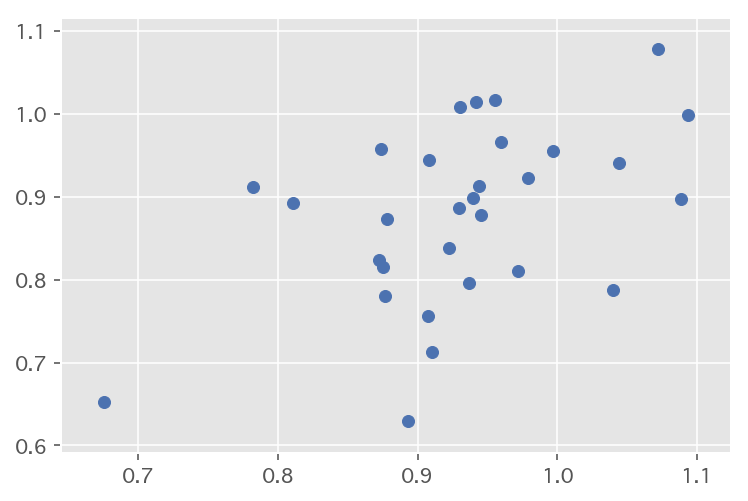

In [6]:
plt.scatter([elem[0] for elem in list(res_dict1.values())], [elem[1] for elem in list(res_dict1.values())])

# n点差以上

In [7]:
#imp_list = []
#det_list = []
res_dict = dict()
for team in teams_mlb:
    lst = triple_on_score_diff(team, 5, 30)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

ロイヤルズ 0.983021211653 0.615804464736
ブリュワーズ 1.39168563365 0.495946197412
パイレーツ 1.12088591317 0.958891366324
ジャイアンツ 0.43924997866 0.616893851828
カブス 1.17958326614 0.726199626644
マーリンズ 0.795297163137 0.794355279834
Wソックス 0.87661194852 0.995997954521
ロッキーズ 1.21690171331 1.01965735045
フィリーズ 1.08743679228 0.904200346908
メッツ 0.86258310196 1.47858841173
ヤンキース 1.24222528971 1.06629156825
レイズ 0.86339786246 1.27659542025
インディアンス 0.96285254836 0.936109436475
アスレチックス 0.935035724883 1.26503500142
Rソックス 0.920814673757 0.571502151552
ドジャース 1.14007487571 0.826814759608
オリオールズ 1.05321615017 0.72934286349
ツインズ 0.845329327581 0.938004070987
タイガース 0.79418685124 0.468906404799
カージナルス 1.00072653552 0.748792089259
マリナーズ 0.930857948265 1.42933588843
パドレス 1.01582960308 0.0634663060627
ブルージェイズ 0.842442353606 0.8423879888
ナショナルズ 1.45815106828 0.569673657433
Dバックス 1.37045785935 0.725705933393
エンゼルス 1.17717432293 0.812090716621
ブレーブス 1.00345716699 0.499212043981
レンジャーズ 0.888430813922 1.04815543786
アストロズ 1.173774306

In [33]:
pd.DataFrame([[elem[0], elem[1][0], elem[1][1]] for elem in list(res_dict.items())]).set_index(0, drop=True)

,1,2
0,,
Rソックス,0.920815,0.571502
ブリュワーズ,1.391686,0.495946
ドジャース,1.140075,0.826815
パイレーツ,1.120886,0.958891
マーリンズ,0.795297,0.794355
カブス,1.179583,0.726200
Wソックス,0.876612,0.995998
オリオールズ,1.053216,0.729343
ロッキーズ,1.216902,1.019657


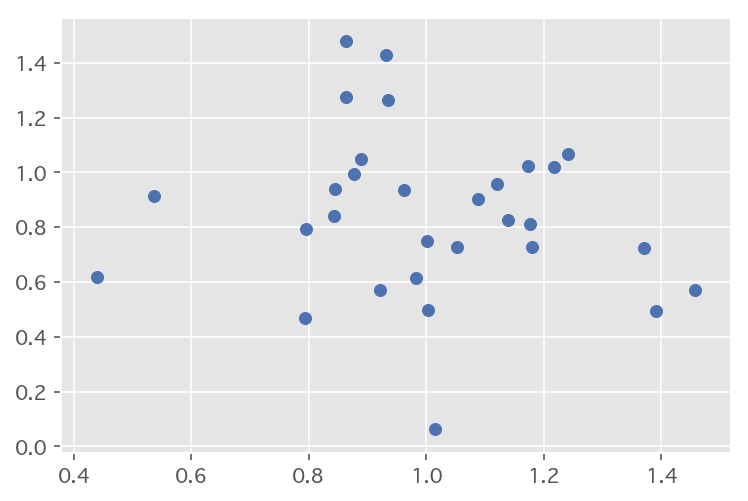

In [8]:
plt.scatter([elem[0] for elem in list(res_dict.values())], [elem[1] for elem in list(res_dict.values())])

In [9]:
# 大差で勝っていると流れがいいとボコボコにするチーム
for team in teams_mlb:
    if res_dict1[team][0] < res_dict[team][0]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])

1 ブリュワーズ 0.347389383509
4 パイレーツ 0.227580633441
2 カブス 0.301344557937
2 ロッキーズ 0.238233574973
3 フィリーズ 0.210671273043
2 ヤンキース 0.148710466711
3 レイズ 0.0815036807268
1 インディアンス 0.0074201870987
1 Rソックス 0.045890117777
1 ドジャース 0.209745824676
5 オリオールズ 0.056099148987
3 カージナルス 0.0711214457542
5 パドレス 0.205135277125
2 ナショナルズ 0.486350159148
3 Dバックス 0.28198606923
4 エンゼルス 0.268728474457
1 ブレーブス 0.0958259546316
1 アストロズ 0.230073681292


In [10]:
# 大差で勝っていると油断するチーム
for team in teams_mlb:
    if res_dict1[team][0] > res_dict[team][0]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])

5 ロイヤルズ -0.0568516930322
4 ジャイアンツ -0.236328884279
5 マーリンズ -0.141291179609
4 Wソックス -0.0689924058337
4 メッツ -0.0113925527959
2 アスレチックス -0.13700249599
2 ツインズ -0.0770867382612
3 タイガース -0.116432025874
3 マリナーズ -0.00900561672181
4 ブルージェイズ -0.0995028528653
5 レンジャーズ -0.0709268271073
5 レッズ -0.336474684912


In [34]:
def pos_neg(team, nlead=5, nbehind=4, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif year == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif year == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
        
    # 点差関係なし
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    all_imp, all_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    #  nlead点差以上リード
    lst = triple_on_score_diff(team, nlead, 30)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    pos_imp, pos_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    # nbehind点差以上ビハインド
    lst = triple_on_score_diff(team, -nbehind, -1)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    neg_imp, neg_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    return [team, all_imp, all_det, pos_imp, pos_det, neg_imp, neg_det]

In [36]:
res = []
for team in teams_mlb:
    curr = pos_neg(team)
    res.append(curr)
    print(curr)

['ロイヤルズ', 1.0398729046852799, 0.78732698945353796, 0.98302121165305101, 0.61580446473592432, 1.0079249341427858, 0.98919268857184872]
['ブリュワーズ', 1.0442962501441819, 0.9413936044140282, 1.391685633653124, 0.49594619741166279, 0.96107955282236979, 0.94372176144912712]
['パイレーツ', 0.89330527972932694, 0.62888207250041794, 1.1208859131704265, 0.95889136632359351, 0.77585521932488188, 0.55033851898890807]
['ジャイアンツ', 0.67557886293898328, 0.65212047822166219, 0.43924997866013105, 0.61689385182826295, 0.75905164814865955, 0.55885389956842613]
['カブス', 0.87823870819907202, 0.87286651343917954, 1.1795832661357988, 0.72619962664443793, 0.80757014203378474, 0.71443266353964918]
['マーリンズ', 0.9365883427463656, 0.79615610317193697, 0.79529716313726806, 0.79435527983431953, 0.81822135584663513, 0.8060304459241785]
['Wソックス', 0.94560435435358892, 0.87807290306233376, 0.87661194851987534, 0.99599795452062845, 0.89280664708724411, 0.80975558243952817]
['ロッキーズ', 0.97866813833820221, 0.92331051782413753, 1.2169

In [122]:
df = pd.DataFrame(res, columns=["チーム", "all_imp", "all_det", "pos_imp", "pos_det", "neg_imp", "neg_det"]).set_index("チーム", drop=True)

In [123]:
df["positive_inhibition"] = - df["pos_imp"] + df["all_imp"]
df["negative_facilitation"] = df["neg_det"] - df["all_det"]

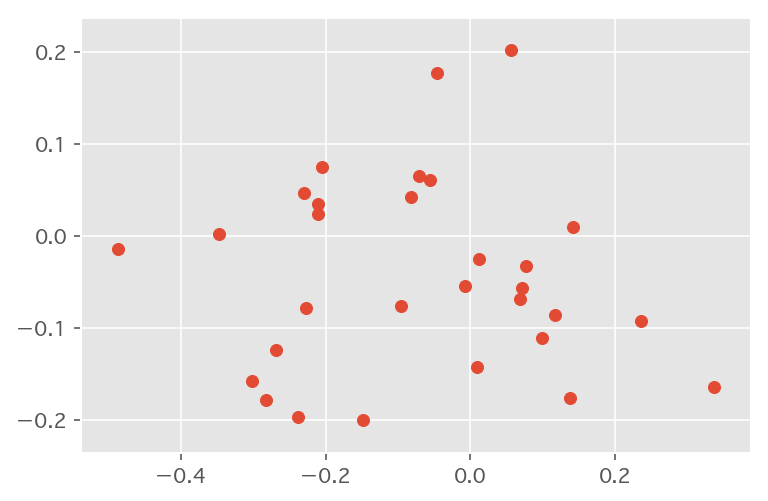

In [124]:
df[["positive_inhibition", "negative_facilitation"]]
plt.scatter(df["positive_inhibition"], df["negative_facilitation"])

In [125]:
"${}:{}$".format(ranking(team), team)

'$5:レッズ$'

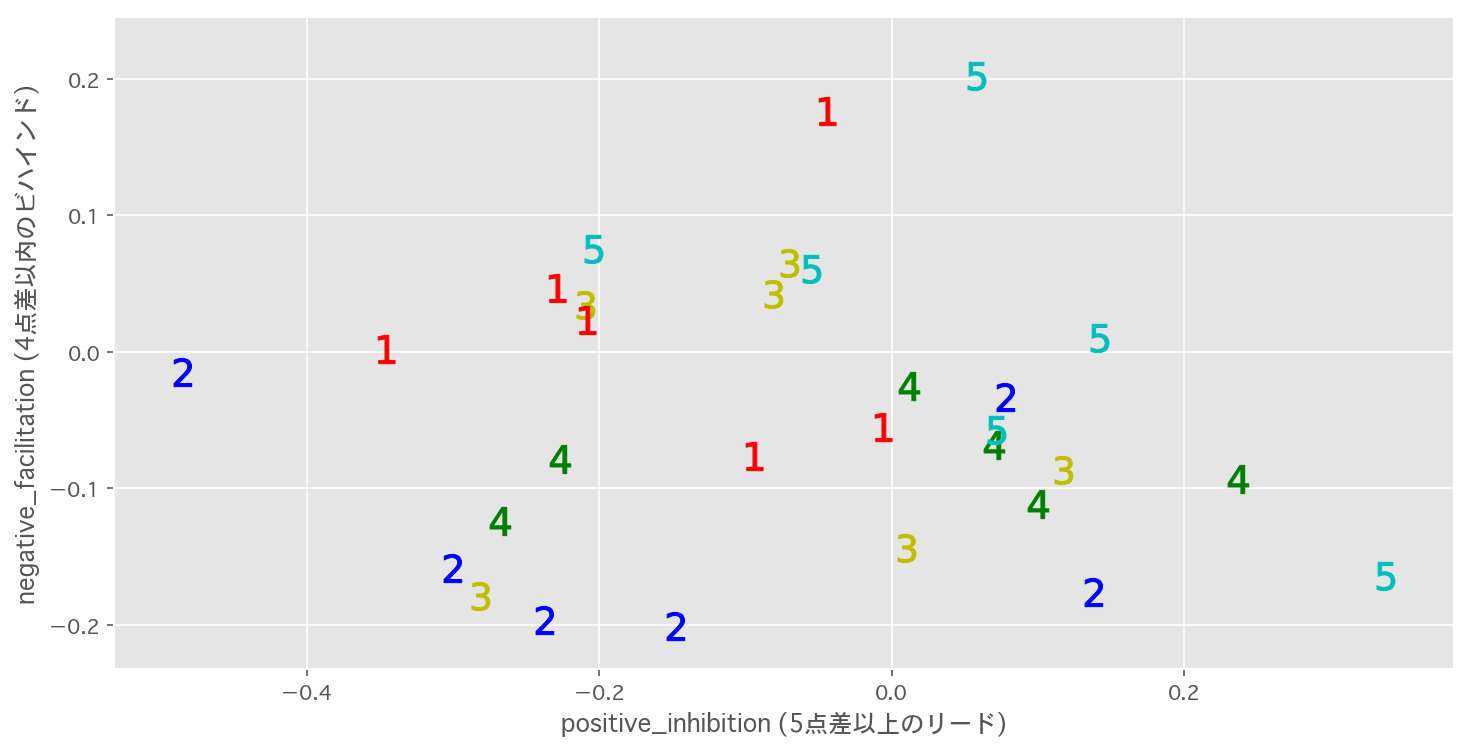

In [126]:
plt.figure(figsize=(12, 6))
colors = ["r", "b", "y", "g", "c"]
for team in df.index:
    pos_inh = df.loc[team, "positive_inhibition"]
    neg_fac = df.loc[team, "negative_facilitation"]
    plt.scatter([pos_inh], [neg_fac], marker="${}$".format(ranking(team)), color=colors[ranking(team)-1], s=200)
plt.xlabel("positive_inhibition (5点差以上のリード)")
plt.ylabel("negative_facilitation (4点差以内のビハインド)")

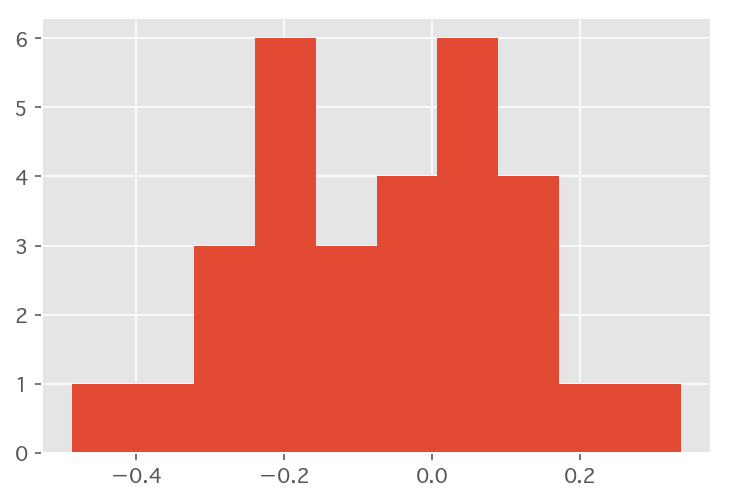

In [128]:
df.loc[:, "positive_inhibition"].hist()

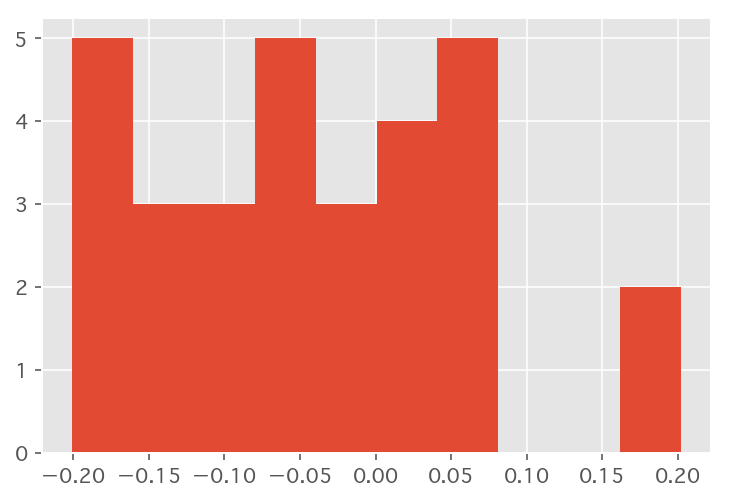

In [129]:
df.loc[:, "negative_facilitation"].hist()

In [42]:
X = pd.DataFrame(res).set_index(0, drop=True).values
teams = pd.DataFrame(res).set_index(0, drop=True).index

In [75]:
from sklearn.cluster import KMeans
model = KMeans(3)

In [76]:
model.fit(X)
model.labels_

array([0, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 2], dtype=int32)

In [77]:
#np.array(teams)[list(map(bool, model.labels_))]

In [78]:
for i in range(len(teams)):
    print(ranking(teams[i]), teams[i], model.labels_[i])

5 ロイヤルズ 0
1 ブリュワーズ 0
4 パイレーツ 1
4 ジャイアンツ 2
2 カブス 0
5 マーリンズ 2
4 Wソックス 1
2 ロッキーズ 1
3 フィリーズ 1
4 メッツ 1
2 ヤンキース 1
3 レイズ 1
1 インディアンス 1
2 アスレチックス 1
1 Rソックス 0
1 ドジャース 0
5 オリオールズ 0
2 ツインズ 1
3 タイガース 2
3 カージナルス 0
3 マリナーズ 1
5 パドレス 0
4 ブルージェイズ 1
2 ナショナルズ 0
3 Dバックス 0
4 エンゼルス 0
1 ブレーブス 0
5 レンジャーズ 1
1 アストロズ 1
5 レッズ 2
